In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 19.9 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=605fd55dd424d4f6aaaffdb3dc59d9ffe918facbb1e65ef991b3a3b68f1e4205
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 987.4/987.4 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headles

In [ ]:
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
import tqdm
import psutil

from google.colab import drive

# create spark session
spark = SparkSession.builder.getOrCreate()

# create spark context
sc = spark.sparkContext

# check how much memory is allocated to spark runtime
mem_info = psutil.virtual_memory()
total_memory_gb = mem_info.total / (1024 * 1024 * 1024)
print("Total Memory Allocated to Spark Runtime:", int(total_memory_gb), "GB")

Total Memory Allocated to Spark Runtime: 334 GB


In [ ]:
# load data
drive.mount('/content/drive')

data = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/cse 547 - HW 2/data.txt", sep = ' ', inferSchema = True)
c1 = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/cse 547 - HW 2/c1.txt", sep = ' ', inferSchema = True)
c2 = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/cse 547 - HW 2/c2.txt", sep = ' ', inferSchema = True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# spark DataFrame API
small = data.select("_c0", "_c1").limit(100)
c1_small = c1.select("_c0", "_c1")
c2_small = c2.select("_c0", "_c1")


# OR spark SQL
data.registerTempTable("data")

query = """
SELECT _c0, _c1
FROM data
LIMIT 100
"""

small = spark.sql(query)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:329: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


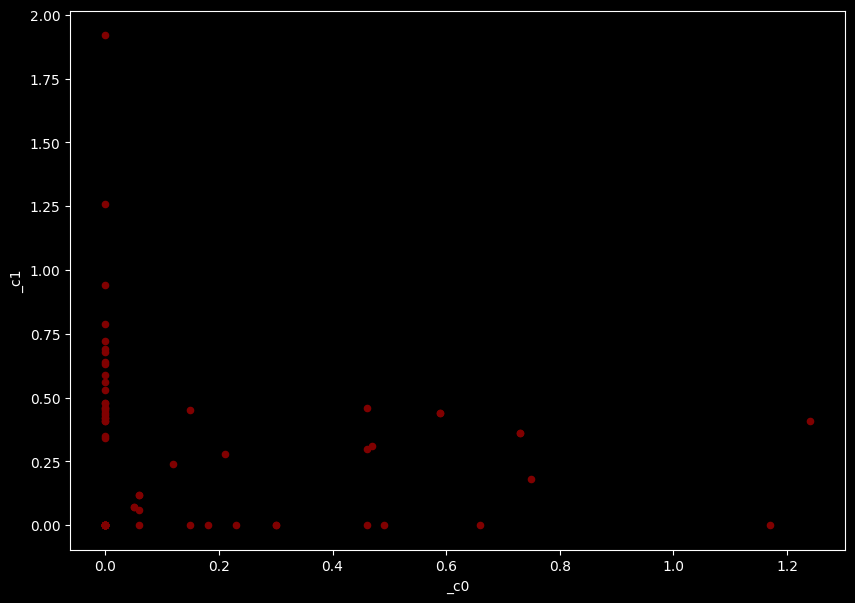

In [ ]:
# print(plt.style.available)
plt.style.use("dark_background")
small_pd = small.toPandas()
small_plot = small_pd.plot.scatter(x = "_c0", y = "_c1",
                           figsize = (10, 7), color = "maroon")

In [ ]:
def K_means(data, centroids, max_iter, norm):

    # convert data, centroids Spark dataframes to NumPy arrays
    data_arr = np.array(data.collect())
    centroid_arr = np.array(centroids.collect())

    # set the number of iterations for K-means
    MAX_ITER = max_iter + 1

    # initialize the cost associated with each iteration
    costs = np.zeros(MAX_ITER)


    # outer-most loop for k-means iterations
    for t in np.arange(MAX_ITER):

        # will store the index corresponding to the cluster into which each
        # point is partitioned
        clusters = np.zeros(data_arr.shape[0])

        # will store the new centroids computed from each iteration
        new_centroids = np.zeros([centroid_arr.shape[0], centroid_arr.shape[1]])

        # will store the count of the number of points falling into each
        # cluster
        point_count = np.zeros([centroid_arr.shape[0], 1])


        # loop over each row in the data
        for j in np.arange(data_arr.shape[0]):

            # will store the 2-norm distance from the current row of the data
            # to each centroid
            dists = np.zeros(centroid_arr.shape[0])


            # loop over each centroid
            for i in np.arange(centroid_arr.shape[0]):

              # calculate the cost(s) for the current row, centroid pair
              x_row = data_arr[j]
              c_row = centroid_arr[i] # can change to c1 or c2
              dists[i] = np.linalg.norm(x_row - c_row, norm)

            # determine the (index of the) cluster with the closest centroid
            # to x_row
            clusters[j] = np.argmin(dists)

            # add the current x_row to the row in the array of new centroids
            # corresponding to the cluster x_row falls into
            new_centroids[int(clusters[j]), :] += x_row
            point_count[int(clusters[j])] += 1

            # store the cost(s) associated with the current x_row
            costs[t] += np.power(dists[int(clusters[j])], norm)

        # divide by the number of points in each cluster to obtain the new
        # centroids
        new_centroids = new_centroids / point_count
        centroid_arr = new_centroids

        # print the cost for each iteration
        print("cost after iteration ", t, ": ", int(costs[t]))

    # return the costs
    return costs

In [ ]:
costs_means_c1 = K_means(data = data, centroids = c1, max_iter = 20, norm = 2);
costs_means_c2 = K_means(data = data, centroids = c2, max_iter = 20, norm = 2);

cost after iteration  0 :  623660345
cost after iteration  1 :  509862908
cost after iteration  2 :  485480681
cost after iteration  3 :  463997011
cost after iteration  4 :  460969266
cost after iteration  5 :  460537847
cost after iteration  6 :  460313099
cost after iteration  7 :  460003523
cost after iteration  8 :  459570539
cost after iteration  9 :  459021103
cost after iteration  10 :  458490656
cost after iteration  11 :  457944232
cost after iteration  12 :  457558005
cost after iteration  13 :  457290136
cost after iteration  14 :  457050555
cost after iteration  15 :  456892235
cost after iteration  16 :  456703630
cost after iteration  17 :  456404203
cost after iteration  18 :  456177800
cost after iteration  19 :  455986871
cost after iteration  20 :  455729268
cost after iteration  0 :  438747790
cost after iteration  1 :  249803933
cost after iteration  2 :  194494814
cost after iteration  3 :  169804841
cost after iteration  4 :  156295748
cost after iteration  5 :  

% change after 10 iterations for means, c1: 0.2648391714456205
% change after 10 iterations for means, c2: 0.7669795594605943


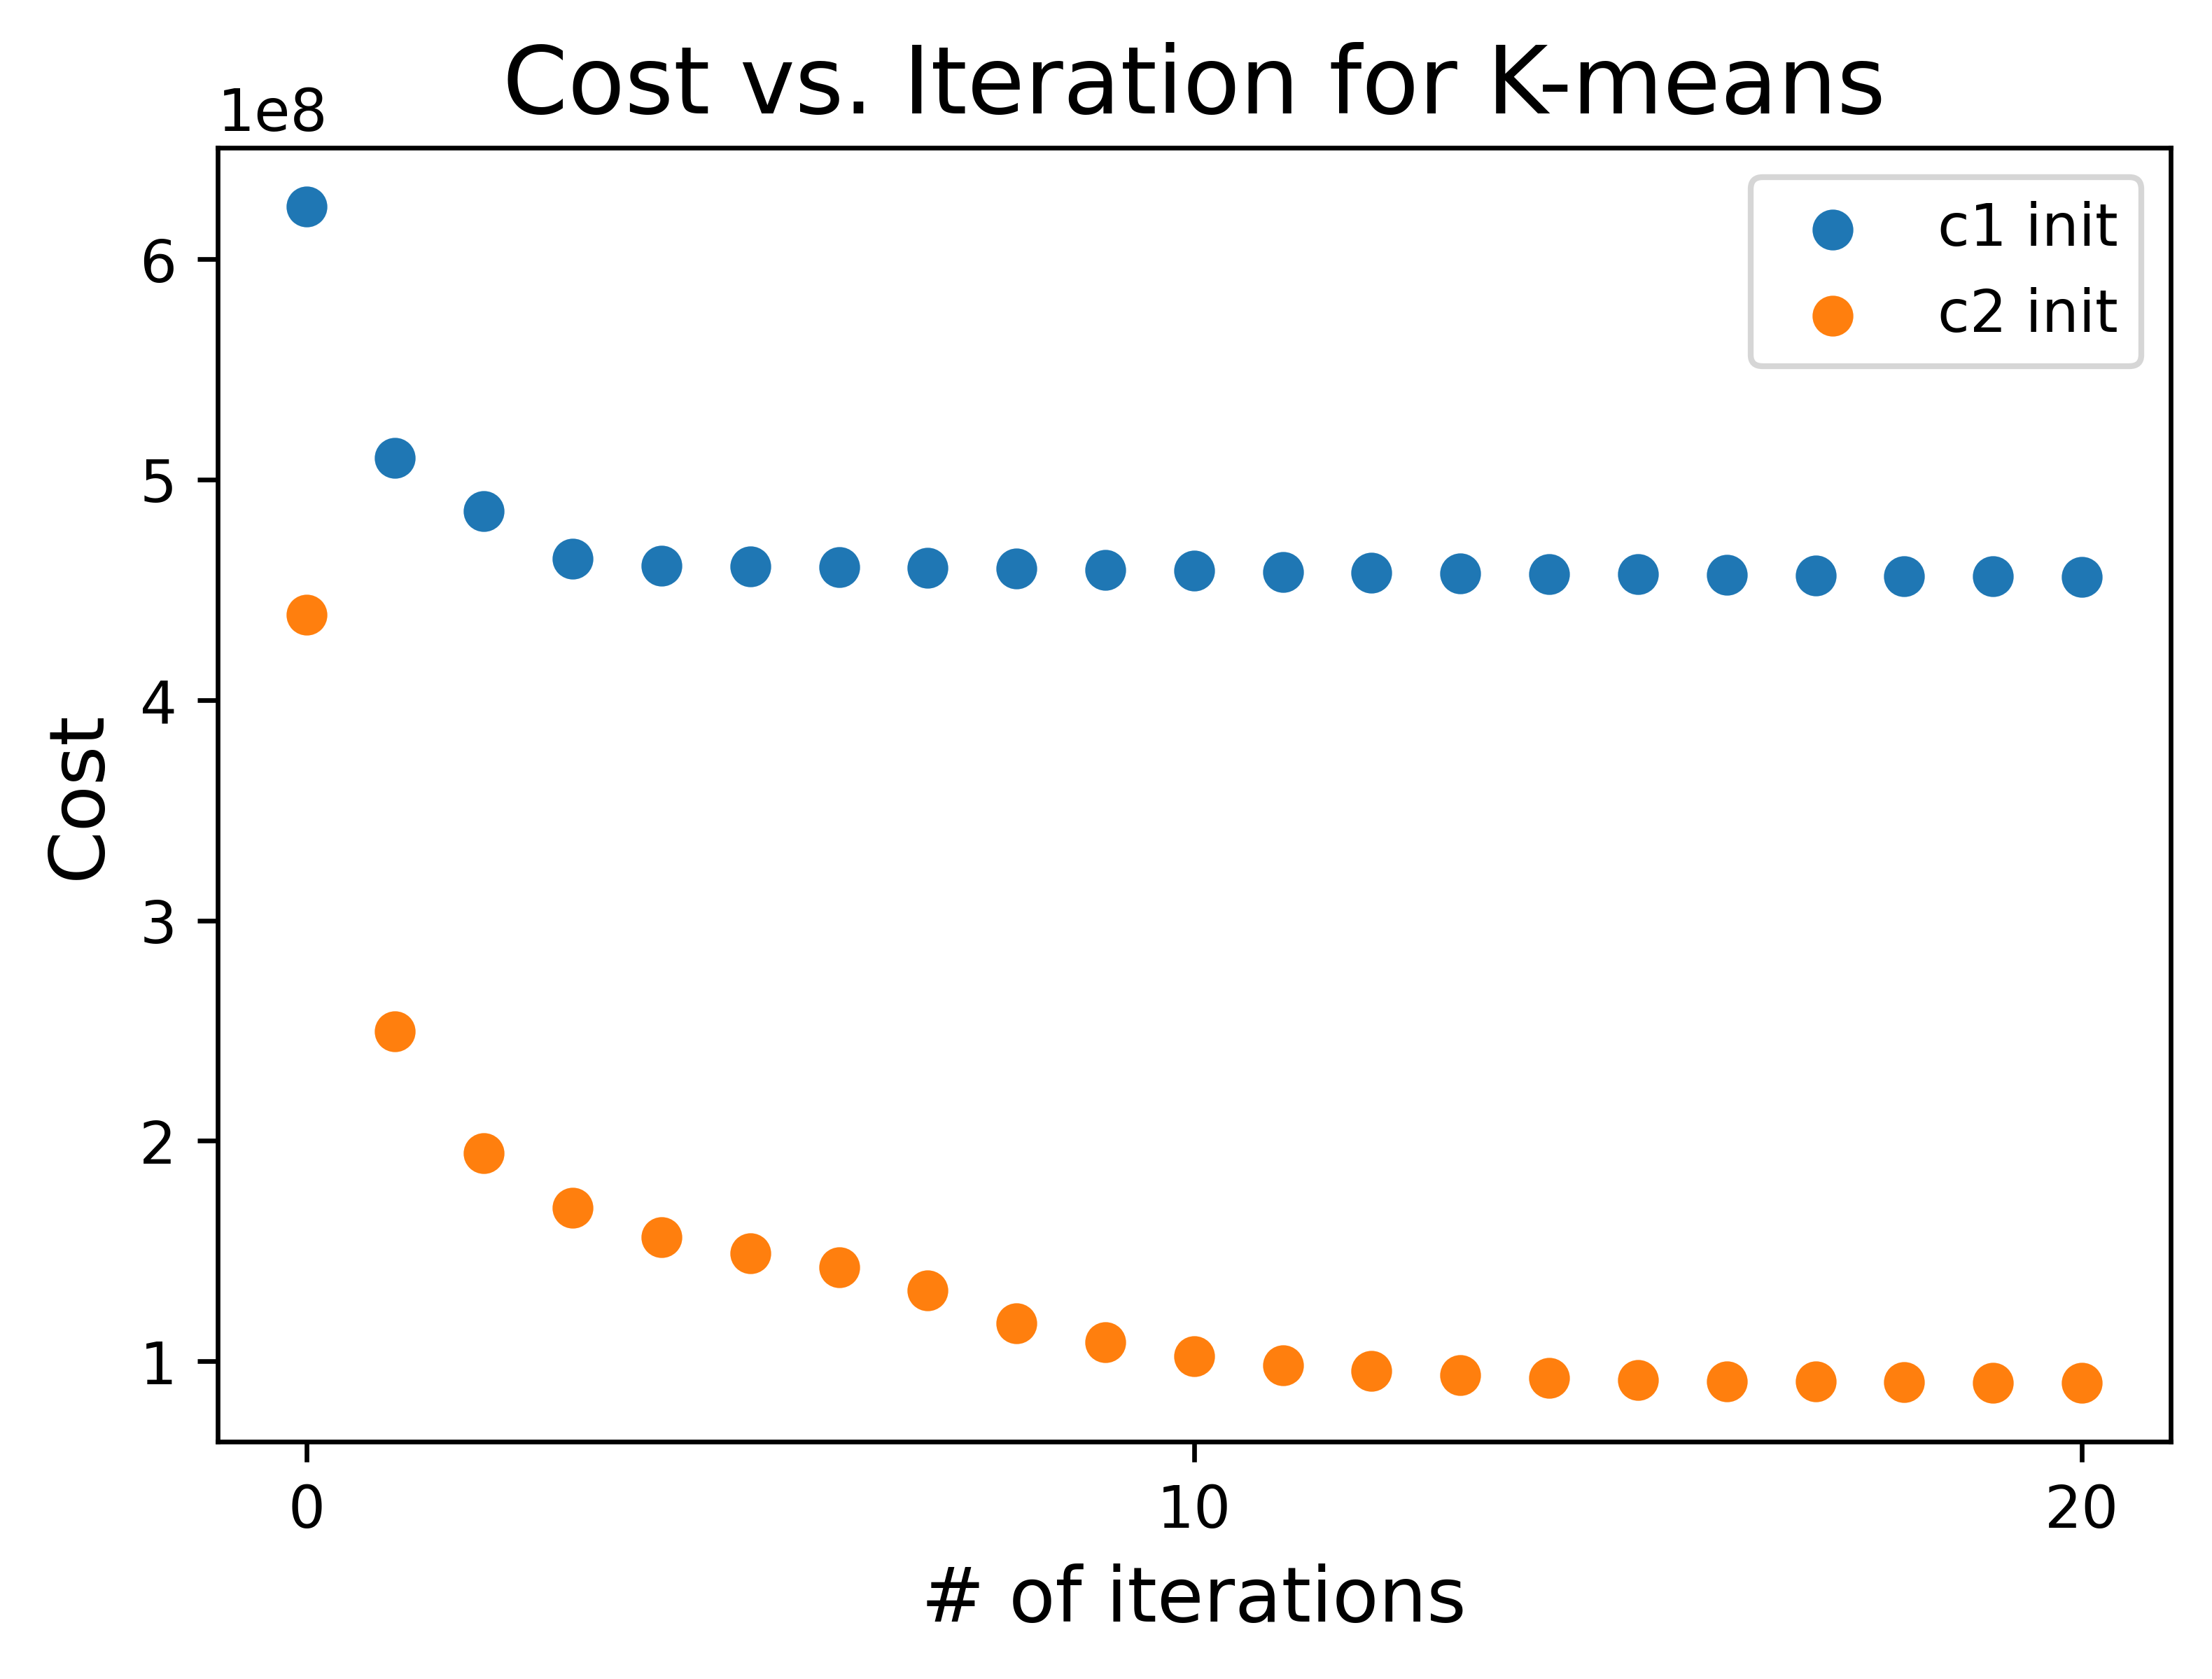

In [ ]:
def pct_change_10(costs):
    return (costs[0] - costs[10]) / costs[0];

print("% change after 10 iterations for means, c1:", pct_change_10(costs_means_c1))
print("% change after 10 iterations for means, c2:", pct_change_10(costs_means_c2))

def plot_costs(costs1, costs2, str):
    plt.style.use('default')
    plt.figure(figsize=(6, 4), dpi=600);
    t = np.linspace(0, 20, 21)
    plt.scatter(t, costs1, label = 'c1 init');
    plt.scatter(t, costs2, label = 'c2 init');
    plt.legend();
    plt.title("Cost vs. Iteration for K-" + str, fontsize = 16);
    plt.xlabel("# of iterations", fontsize = 13);
    plt.ylabel("Cost", fontsize = 13);
    plt.xticks([0, 10 , 20]);
    plt.show();
    return 1;

plot_costs(costs_means_c1, costs_means_c2, "means");

In [ ]:
def K_medians(data, centroids, max_iter, norm):

    # convert data, centroids Spark dataframes to NumPy arrays
    data_arr = np.array(data.collect())
    centroid_arr = np.array(centroids.collect())

    # set the number of iterations for K-medians
    MAX_ITER = max_iter + 1

    # initialize the cost associated with each iteration
    costs = np.zeros(MAX_ITER)


    # outer-most loop for k-medians iterations
    for t in np.arange(MAX_ITER):

        # will store the index corresponding to the cluster into which each
        # point is partitioned
        clusters = np.zeros(data_arr.shape[0])

        # will store the new centroids computed from each iteration
        new_centroids = np.zeros([centroid_arr.shape[0], centroid_arr.shape[1]])


        # loop over each row in the data
        for j in np.arange(data_arr.shape[0]):

            # will store the 1-norm distance from the current row of the data
            # to each centroid
            dists = np.zeros(centroid_arr.shape[0])


            # loop over each centroid
            for i in np.arange(centroid_arr.shape[0]):

              # calculate the cost(s) for the current row, centroid pair
              x_row = data_arr[j]
              c_row = centroid_arr[i] # can change to c1 or c2
              dists[i] = np.linalg.norm(x_row - c_row, norm)

            # determine the (index of the) cluster with the closest centroid
            # to x_row
            clusters[j] = np.argmin(dists)

            # store the cost(s) associated with the current x_row
            costs[t] += dists[int(clusters[j])]

        # calculate the median of each cluster
        for k in range(centroid_arr.shape[0]):
              xs = data_arr[clusters == k]
              new_centroids[k] = np.median(xs, axis = 0)

        # update the centroids to be the calculated medians
        centroid_arr = new_centroids

        # print the cost for each iteration
        print("cost after iteration ", t, ": ", int(costs[t]))

    # return the costs
    return costs

In [ ]:
costs_medians_c1 = K_medians(data = data, centroids = c1, max_iter = 20, norm = 1);
costs_medians_c2 = K_medians(data = data, centroids = c2, max_iter = 20, norm = 1);

cost after iteration  0 :  550117
cost after iteration  1 :  425113
cost after iteration  2 :  415998
cost after iteration  3 :  414568
cost after iteration  4 :  413757
cost after iteration  5 :  412012
cost after iteration  6 :  410834
cost after iteration  7 :  409334
cost after iteration  8 :  408245
cost after iteration  9 :  407715
cost after iteration  10 :  407337
cost after iteration  11 :  406723
cost after iteration  12 :  406388
cost after iteration  13 :  406231
cost after iteration  14 :  406130
cost after iteration  15 :  406073
cost after iteration  16 :  406005
cost after iteration  17 :  405987
cost after iteration  18 :  405974
cost after iteration  19 :  405949
cost after iteration  20 :  405884
cost after iteration  0 :  1433739
cost after iteration  1 :  882840
cost after iteration  2 :  776690
cost after iteration  3 :  736546
cost after iteration  4 :  701873
cost after iteration  5 :  618738
cost after iteration  6 :  592289
cost after iteration  7 :  577263
co

% change after 10 iterations for medians, c1: 0.25954358008354333
% change after 10 iterations for medians, c2: 0.6213918226180132


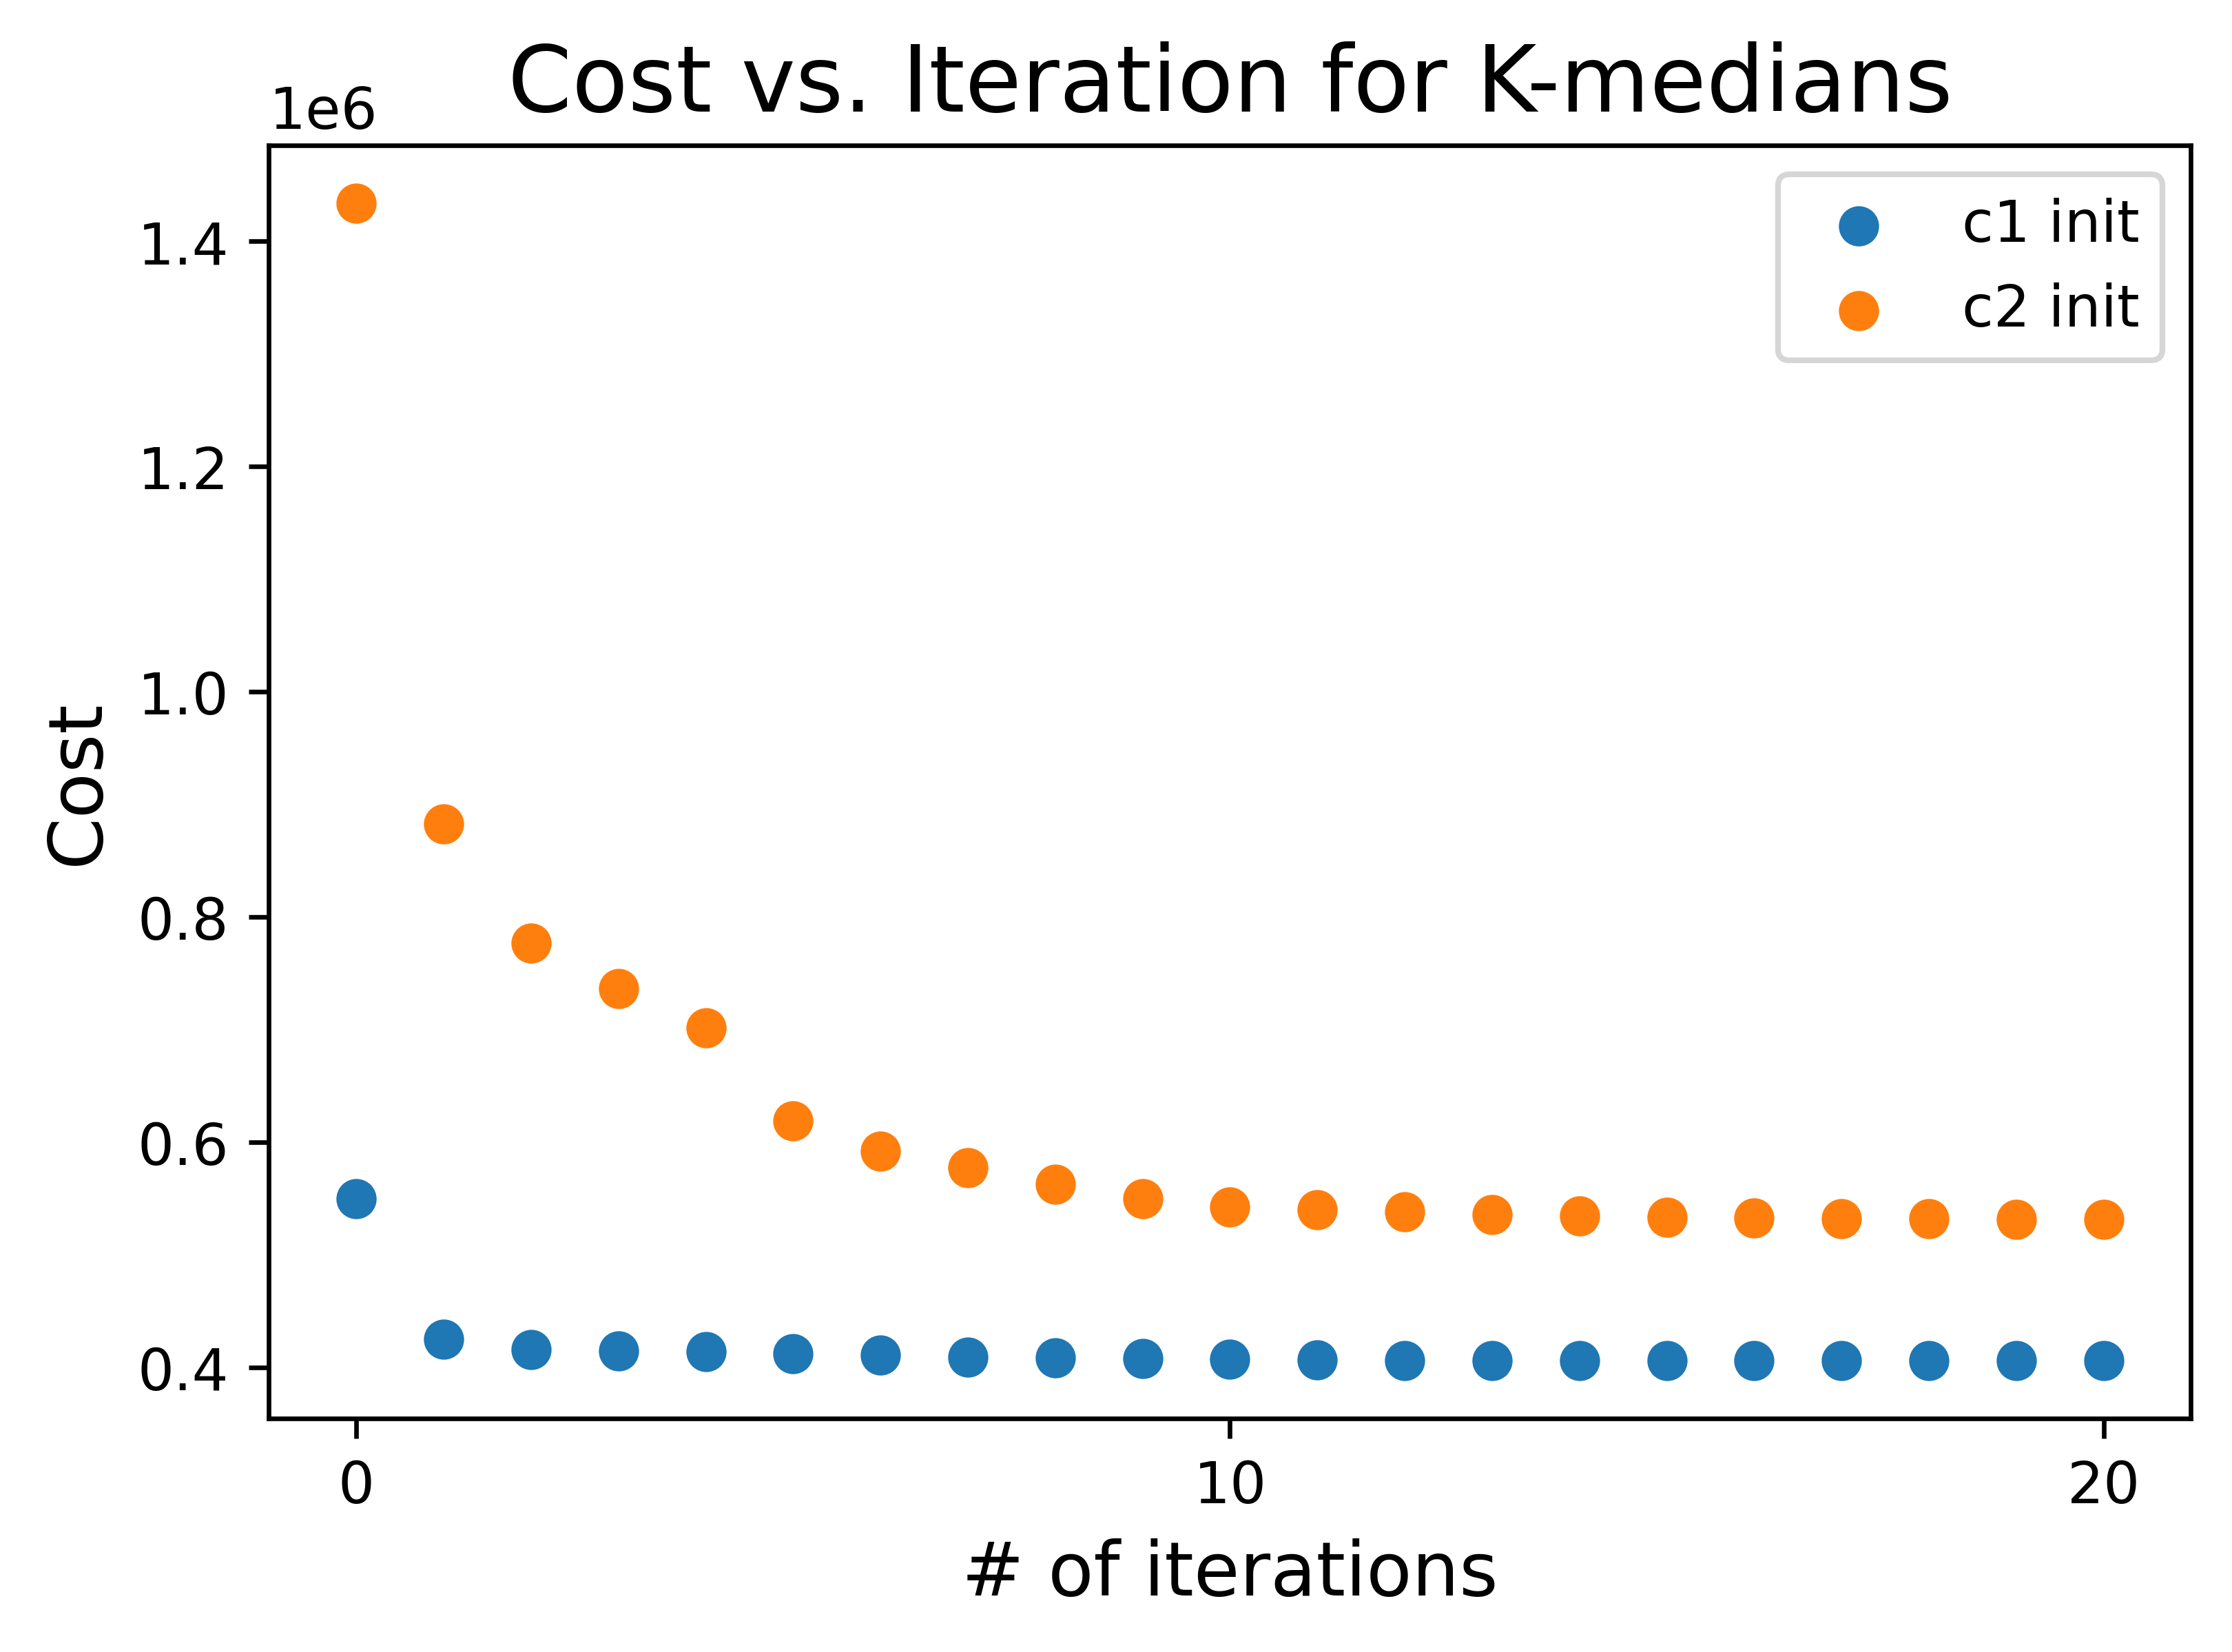

In [ ]:
print("% change after 10 iterations for medians, c1:", pct_change_10(costs_medians_c1))
print("% change after 10 iterations for medians, c2:", pct_change_10(costs_medians_c2))

plot_costs(costs_medians_c1, costs_medians_c2, "medians");